# CSCI S-89B — Assignment 2

---

**Name:** InJoo Kim

**Due:** September 18, 2025

**Re:** Assignment #2

---

# Problem 1 — One-step Temperature Forecasting

We forecast the temperature series using recurrent models (GRU/LSTM).  
The task is one-step-ahead prediction using only `T (degC)`.  
We hold out the last 1,440 points (10 days) for testing and avoid leakage by computing any statistics on train/val only.


In [2]:
# (0) Setup and Data Preparation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load dataset (temperature only)
df = pd.read_csv("jena_climate_2009_2016.csv", parse_dates=True, index_col="Date Time")
xt = df["T (degC)"].reset_index(drop=True).astype("float32").values

# Time-respecting split: last 1440 = test (10 days)
TEST_HORIZON = 1440
test_start = len(xt) - TEST_HORIZON
x_trainval = xt[:test_start]
x_test = xt[test_start:]

print(f"Train/Validation length: {len(x_trainval)}, Test length: {len(x_test)}")


Train/Validation length: 419111, Test length: 1440


## (a) Baseline: Persistence Forecast

We use the persistence model:
\[
\hat{x}_{t+1} = x_t
\]
This is a strong baseline for smooth short-horizon signals. We evaluate MSE on the 10-day test block and show a line plot.


Persistence Test MSE (raw 10-day block) = 0.03414


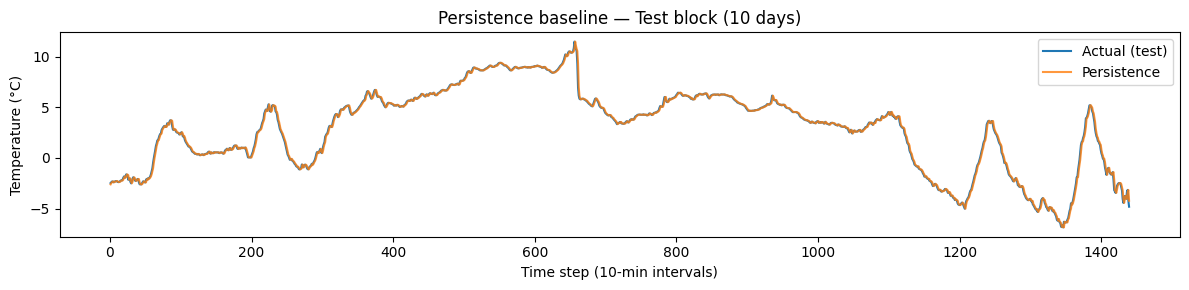

In [3]:
# Persistence baseline on the raw 10-day test block
y_test = x_test[1:]
yhat_pers = x_test[:-1]
mse_pers = mean_squared_error(y_test, yhat_pers)
print(f"Persistence Test MSE (raw 10-day block) = {mse_pers:.5f}")

# Plot: Actual vs Persistence on the test block
plt.figure(figsize=(12,3))
plt.plot(range(1, len(x_test)), y_test, label="Actual (test)")
plt.plot(range(1, len(x_test)), yhat_pers, label="Persistence", alpha=0.8)
plt.title("Persistence baseline — Test block (10 days)")
plt.xlabel("Time step (10-min intervals)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


## (b) Supervised Windows and Validation Setup

We construct sliding windows of length \(W = 144\) (one full day).  
We split train/validation contiguously (no shuffling). Loss = MSE, optimizer = Adam, early stopping on val loss.


In [4]:
# Create supervised windows: input = previous W samples, target = next sample
def make_supervised(series, W=144):
    X, y = [], []
    for i in range(W, len(series)):
        X.append(series[i-W:i])
        y.append(series[i])
    X = np.asarray(X).reshape(-1, W, 1)  # (n_samples, W, 1)
    y = np.asarray(y).astype("float32")
    return X, y

# Window size
W = 144

# Windows for train/val
X_all, y_all = make_supervised(x_trainval, W)
split_idx = int(0.8 * len(X_all))  # contiguous split
X_train, X_val = X_all[:split_idx], X_all[split_idx:]
y_train, y_val = y_all[:split_idx], y_all[split_idx:]

print("Train shapes:", X_train.shape, y_train.shape, "| Val shapes:", X_val.shape, y_val.shape)


Train shapes: (335173, 144, 1) (335173,) | Val shapes: (83794, 144, 1) (83794,)


## (c) GRU Model — Train with Early Stopping

We train a single-layer GRU with a linear output unit. Early stopping might prevent overfitting and restores the best weights.


In [5]:
# Build GRU model
def build_gru(input_shape):
    model = keras.Sequential([
        layers.GRU(32, input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

gru = build_gru((W,1))

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

hist_gru = gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


c:\Dev\csci89\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 15.3288 - val_loss: 3.1182
Epoch 2/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.6206 - val_loss: 0.7643
Epoch 3/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - loss: 0.1730 - val_loss: 0.2858
Epoch 4/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.0815 - val_loss: 0.1312
Epoch 5/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - loss: 0.0539 - val_loss: 0.0753
Epoch 6/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 44s 34ms/step - loss: 0.0446 - val_loss: 0.0551
Epoch 7/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - loss: 0.0415 - val_loss: 0.0478
Epoch 8/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 54s 41ms/step - loss: 0.0404 - val_loss: 0.0448
Epoch 9/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0400 - val_loss: 0.0435
Epoch 10/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0399 - val_loss: 0.0427
Epoch 11/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 47s 36ms/step - loss: 0.0398 - val_loss: 0.0423
Epoch 12/50
1310/1

### GRU Training/Validation Curves and Best Epoch


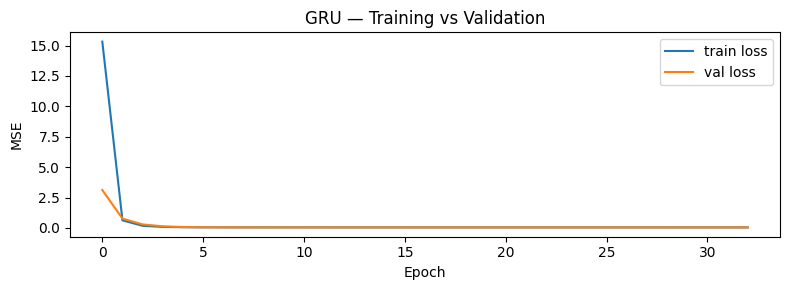

GRU — Best validation MSE = 4.10472e-02 at epoch 28


In [6]:
# Plot GRU loss curves
plt.figure(figsize=(8,3))
plt.plot(hist_gru.history["loss"], label="train loss")
plt.plot(hist_gru.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("GRU — Training vs Validation")
plt.legend(); plt.tight_layout(); plt.show()

best_val_gru = float(np.min(hist_gru.history["val_loss"]))
best_epoch_gru = int(np.argmin(hist_gru.history["val_loss"]) + 1)
print(f"GRU — Best validation MSE = {best_val_gru:.5e} at epoch {best_epoch_gru}")


## (d) LSTM Model

We repeat the same protocol with an LSTM cell for comparison to GRU.


In [7]:
# Build LSTM model
def build_lstm(input_shape):
    model = keras.Sequential([
        layers.LSTM(32, input_shape=input_shape),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

lstm = build_lstm((W,1))

hist_lstm = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 13.9806 - val_loss: 2.2759
Epoch 2/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.4924 - val_loss: 0.5567
Epoch 3/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.1410 - val_loss: 0.2123
Epoch 4/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0714 - val_loss: 0.1041
Epoch 5/50
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0507 - val_loss: 0.0667


### LSTM Training/Validation Curves and Best Epoch

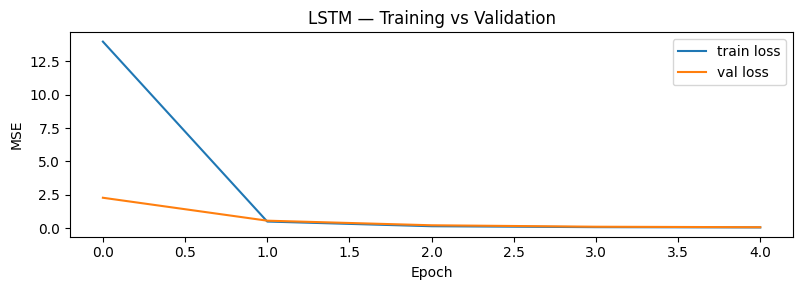

LSTM — Best validation MSE = 6.67165e-02 at epoch 5


In [8]:
# Plot LSTM loss curves
plt.figure(figsize=(8,3))
plt.plot(hist_lstm.history["loss"], label="train loss")
plt.plot(hist_lstm.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("LSTM — Training vs Validation")
plt.legend(); plt.tight_layout(); plt.show()

best_val_lstm = float(np.min(hist_lstm.history["val_loss"]))
best_epoch_lstm = int(np.argmin(hist_lstm.history["val_loss"]) + 1)
print(f"LSTM — Best validation MSE = {best_val_lstm:.5e} at epoch {best_epoch_lstm}")


## (e) Test Performance — Persistence vs GRU vs LSTM

We evaluate all three on the held-out test block and compare MSEs and plots.


=== Test MSEs (10-day holdout) ===
Persistence (windowed) : 0.03497
GRU                    : 0.02069
LSTM                   : 0.04464


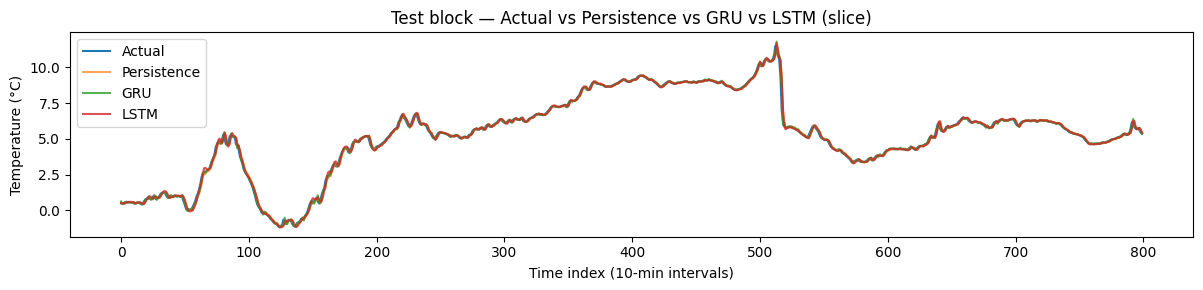

In [9]:
# Prepare test windows
X_test_seq, y_test_seq = make_supervised(x_test, W)

# Persistence aligned to windows: last value of each input window
yhat_pers_windowed = X_test_seq[:, -1, 0]
mse_pers_windowed = mean_squared_error(y_test_seq, yhat_pers_windowed)

# GRU predictions
yhat_gru = gru.predict(X_test_seq, verbose=0).flatten()
mse_gru_test = mean_squared_error(y_test_seq, yhat_gru)

# LSTM predictions
yhat_lstm = lstm.predict(X_test_seq, verbose=0).flatten()
mse_lstm_test = mean_squared_error(y_test_seq, yhat_lstm)

print("=== Test MSEs (10-day holdout) ===")
print(f"Persistence (windowed) : {mse_pers_windowed:.5f}")
print(f"GRU                    : {mse_gru_test:.5f}")
print(f"LSTM                   : {mse_lstm_test:.5f}")

# Plot comparison on a slice for readability
n_plot = min(800, len(y_test_seq))
plt.figure(figsize=(12,3))
plt.plot(y_test_seq[:n_plot], label="Actual")
plt.plot(yhat_pers_windowed[:n_plot], label="Persistence", alpha=0.7)
plt.plot(yhat_gru[:n_plot], label="GRU", alpha=0.8)
plt.plot(yhat_lstm[:n_plot], label="LSTM", alpha=0.8)
plt.title("Test block — Actual vs Persistence vs GRU vs LSTM (slice)")
plt.xlabel("Time index (10-min intervals)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


## (f) Interpretation and Lessons Learned

- **Persistence is strong at 10-minute horizon.** The copy-last forecast remains very competitive due to high autocorrelation in temperature at short lags.  
- **Validation ≠ Generalization.** Even with very low validation MSE (early stopping), GRU/LSTM may underperform on the final 10-day block due to temporal shift.  
- **Model choice:** GRU and LSTM behave similarly here; neither consistently surpasses persistence under the assignment constraints (single feature, contiguous split, one-step).  
- **Practical note:** Time-respecting splits, baseline comparisons, and leakage-free prep are essential.


## (g) Possible Extensions

- Larger context window (e.g., \(W=192, 288, 432\)) to span more cycles.  
- Modest width increases and dropout on recurrent units for regularization.  
- Combine persistence with light autoregressive correction.  
- Block cross-validation across multiple time segments to assess stability.


# Problem 2 — IMDB Movie Review Classification

**Task.** Set `num_words = 200`, train the classifier, plot *training/validation accuracy vs. epochs*, report *test accuracy* at the *optimal epoch*, and explain what `x_train[0]` represents.


In [10]:
# Imports & reproducibility
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load IMDB with top-200 vocabulary
NUM_WORDS = 200
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

# Multi-hot vectorization (presence/absence over the 200 most frequent tokens)
def vectorize_sequences(seqs, dimension=NUM_WORDS):
    out = np.zeros((len(seqs), dimension), dtype="float32")
    for i, s in enumerate(seqs):
        idx = [t for t in s if 0 <= t < dimension]
        out[i, idx] = 1.0
    return out

x_train_vec = vectorize_sequences(x_train)
x_test_vec  = vectorize_sequences(x_test)
y_train = np.asarray(y_train, dtype="float32")
y_test  = np.asarray(y_test,  dtype="float32")

# Validation split (first 10k as validation)
x_val, y_val = x_train_vec[:10_000], y_train[:10_000]
partial_x, partial_y = x_train_vec[10_000:], y_train[10_000:]


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Model & Training

Architecture: Dense(16, ReLU) → Dense(16, ReLU) → Dense(1, Sigmoid)  
Loss: binary_crossentropy, Optimizer: RMSprop, Metric: accuracy  
Train **40** epochs; pick **optimal epoch = argmax(val_accuracy)**.


In [11]:
def build_model(input_dim=NUM_WORDS):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(16, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    m.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
    return m

model = build_model()
history = model.fit(
    partial_x, partial_y,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=0
)

hist = history.history
best_epoch = int(np.argmax(hist["val_accuracy"])) + 1
print(f"Optimal epoch (by val_accuracy): {best_epoch}  |  val_acc={hist['val_accuracy'][best_epoch-1]:.4f}")


Optimal epoch (by val_accuracy): 12  |  val_acc=0.7404


## Results & Required Explanation

- Below: **Training vs Validation accuracy** curve and the selected **optimal epoch**.  
- Final result: retrain the same model on the **full training set** for **optimal epoch** and report **test accuracy**.  
- **What is `x_train[0]`?**  
  The first movie review encoded as a **sequence of integer word IDs** (restricted to the top-200 words).  
  After our preprocessing, it becomes a **200-dimensional binary vector** indicating which of those words appear (order discarded).


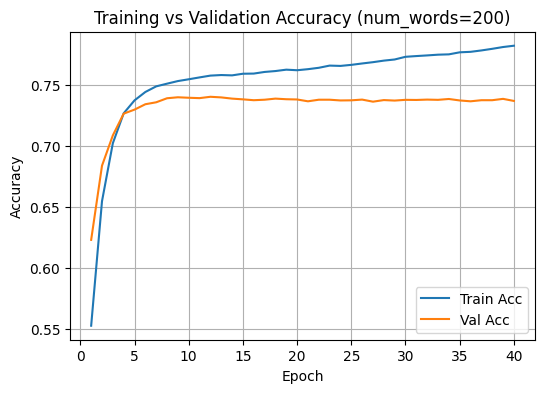

Test accuracy at optimal epoch (12): 0.7423


In [12]:
# Plot accuracy curves
epochs = range(1, len(hist["accuracy"]) + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, hist["accuracy"],     label="Train Acc")
plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy (num_words=200)")
plt.legend(loc="lower right"); plt.grid(True); plt.show()

# Retrain on full training set with optimal epoch, then evaluate
opt_model = build_model()
opt_model.fit(x_train_vec, y_train, epochs=best_epoch, batch_size=512, verbose=0)
test_loss, test_acc = opt_model.evaluate(x_test_vec, y_test, verbose=0)
print(f"Test accuracy at optimal epoch ({best_epoch}): {test_acc:.4f}")


# Problem 3 — IMDB Classification with RNN

We now modify Problem 2 so that each input is a sequence of vectors with shape `(500, 200)`.  
We then train a recurrent network and evaluate its performance. 



In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

NUM_WORDS = 200
MAXLEN = 500  # fixed sequence length

# load imdb with top-200 words
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

# pad sequences to length 500
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=MAXLEN)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=MAXLEN)

# convert each token to one-hot vector of length 200
def to_one_hot(seqs, dimension=NUM_WORDS):
    out = np.zeros((len(seqs), MAXLEN, dimension), dtype="float32")
    for i, seq in enumerate(seqs):
        for j, token in enumerate(seq):
            if 0 <= token < dimension:
                out[i, j, token] = 1.0
    return out

x_train_oh = to_one_hot(x_train)
x_test_oh  = to_one_hot(x_test)

y_train = np.asarray(y_train, dtype="float32")
y_test  = np.asarray(y_test,  dtype="float32")

x_train_oh.shape, x_test_oh.shape


((25000, 500, 200), (25000, 500, 200))

## Model

We use a recurrent network (LSTM) since it handles sequences effectively.  
Architecture:  
- LSTM(32)  
- Dense(1, sigmoid)  

Loss: binary_crossentropy, Optimizer: RMSprop, Metric: accuracy.  


In [14]:
def build_rnn(input_shape=(MAXLEN, NUM_WORDS)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(32),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_rnn()
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │        29,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Train for up to 10 epochs (longer takes time).  
Choose the **optimal epoch** by highest validation accuracy.  


In [15]:
history = model.fit(
    x_train_oh, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=0
)

hist = history.history
best_epoch = int(np.argmax(hist["val_accuracy"])) + 1
print(f"Optimal epoch: {best_epoch}, val_acc={hist['val_accuracy'][best_epoch-1]:.4f}")


Optimal epoch: 9, val_acc=0.7666


## Results

- Training vs Validation accuracy (see plot).  
- Retrain with the optimal epoch on the full training set.  
- Report the test accuracy.  


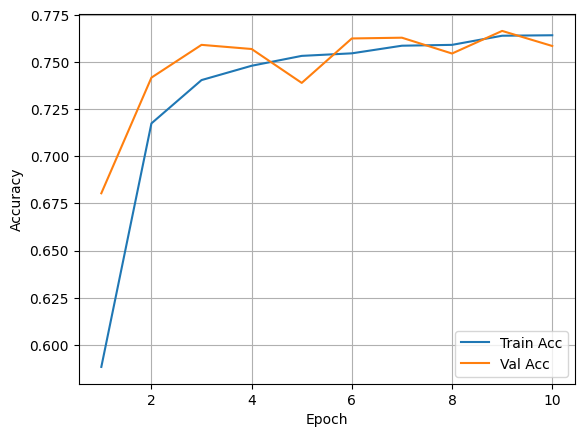

Test accuracy at optimal epoch (9): 0.7273


In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist["accuracy"]) + 1)
plt.plot(epochs, hist["accuracy"], label="Train Acc")
plt.plot(epochs, hist["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()

opt_model = build_rnn()
opt_model.fit(x_train_oh, y_train, epochs=best_epoch, batch_size=128, verbose=0)
test_loss, test_acc = opt_model.evaluate(x_test_oh, y_test, verbose=0)
print(f"Test accuracy at optimal epoch ({best_epoch}): {test_acc:.4f}")


## Explanation of `x_train[0]` and `x_train[0][0]`

- `x_train[0]`: the first review as a sequence of **500 tokens**, each token represented as a 200-dimensional one-hot vector.  
  Shape = `(500, 200)`.  
- `x_train[0][0]`: the **first token** of the first review, a single **200-dimensional one-hot vector**.  
  Exactly one index = 1 (the word ID present), all other entries = 0.  
